<a href="https://colab.research.google.com/github/ashmcmn/brain_MRI_estimations/blob/master/qBOLD_Model_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The qBOLD model/method allows for the evaluation of bio-physiological parameters such as oxygen extraction fraction (OEF), deoxygenated blood volume (DBV) and reversible transverse relaxation rate ($R'_2$). This notebook details various implementations of the method in an attempt to maximise the accuracy of these predictions. If you want to read in detail about the theory of qBOLD, I recommend reading the paper "Quantitative BOLD: Mapping of human cerebral deoxygenated blood volume and oxygen extraction fraction:  Default state" by He, X. & Yablonskiy, D. A. from 2007.

In [79]:
import nibabel as nib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

!gdown --id '1zTZoh71HXmT3EBPkm0ku5ySEcjX3l98l'
img = nib.load('slice4_ASE.nii.gz')

Downloading...
From: https://drive.google.com/uc?id=1zTZoh71HXmT3EBPkm0ku5ySEcjX3l98l
To: /content/slice4_ASE.nii.gz
100% 149k/149k [00:00<00:00, 44.0MB/s]


# The Data
Here's a quick look into the data provided. Typically, when fetching data from a .nii file it is of shape (a, b, c, d) where a and b define the image resolution, c is the number of slices and d is the number time intervals the data was recorded at (post-excitation). The data sample used here is a single slice of resolution 96x96, recorded at 11 different time intervals. These time intervals are the delays from initial excitation at which the signals are measured. The 'tau' values for this fMRI scan ranged from -16ms to 64ms at a step of 8ms, such that the first three values are -16ms, -8ms and 0ms. Rendering the images in chronological order below visualizes the measurements of signals recorded during the ASE pulse sequence. You can see the signal strength decay over time.

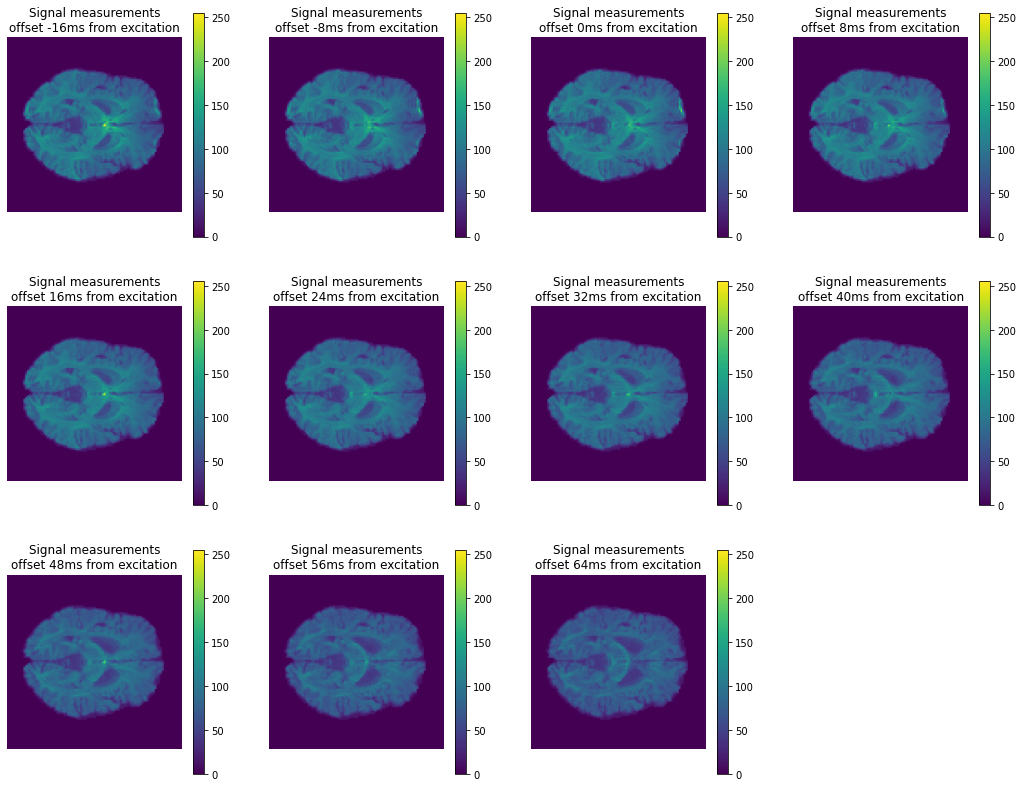

In [142]:
data = img.get_fdata().reshape((96, 96, 11))
taus = range(-16,65,8)

fig, axes = plt.subplots(3, 4, figsize=(18, 14))
axes = axes.ravel()
[a.set_axis_off() for a in axes.ravel()]

for t in range(data.shape[2]):
  im = axes[t].imshow(data[:,:,t], vmax=255)
  plt.colorbar(im, ax=axes[t])
  axes[t].set_title('Signal measurements\noffset {}ms from excitation'.format(taus[t]))

If we a single pixel of the image from an area with varying signal strength over time we can visualize the decay. The general idea is to create a system that, when given data like this, can predict the aforementioned parameters, accurately.

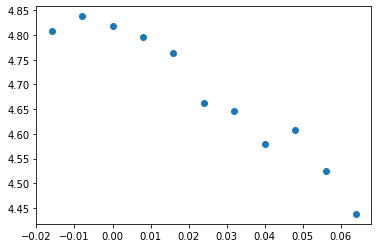

In [375]:
excerpt = np.log(data[50,50,:])
plt.scatter(taus, excerpt)

# Linear Evaluation of Parameters Using Linear Regression
Taking a look at the visualisation of data above and compare it the brilliant figure below from the 2017 paper by A.J. Stone and N.P. Blockley. We can see captured signals can be characterized by the qBOLD signal. If we use linear regression on the data, knowing that the signal decay is equivalent to $R'_2$, we can take the gradient of the solution to be $R'_2$. DBV can then be calculated using the intercept of the solution, that just leaves OEF. OEF can be calculated from the deoxyhaemoglobin concentration (dHb) and the haemoglobin concentration (Hb). dHb can be calculated from $R'_2$ and DBV assuming knowledge of other constants, Hb can be inferred given the expected proportion of hematocrit and finally then OEF can be calculated using these values. In practice OEF is simplified into a single equation.

![](https://drive.google.com/uc?export=view&id=1mqvTHTVoS-B-jkNDJRyzv3t_lTwj-zw0)

In [376]:
class QBOLD_LR():
  def __init__(self, hct, dMagSus, pGyro, fStr, oCap, cTime, tConf):
    self.hct = hct
    self.dMagSus = dMagSus
    self.pGyro = pGyro
    self.fStr = fStr
    self.oCap = oCap
    self.cTime = cTime
    [tStart, tEnd, tStep] = tConf
    self.taus = np.array(range(tStart, tEnd+1, tStep))*10**-3

  def _fit_single(self, xdata):
    x = np.vstack([self.taus, np.ones_like(taus)])
    idx = np.where(self.taus > self.cTime)[0]
    x = np.take(x, idx, axis=1)
    xdata = np.take(xdata, idx)
    return np.dot(np.linalg.pinv(x).T, xdata.reshape(xdata.shape[0],1)).flatten()

  def fit(self, xdata):
    self.data = xdata
    dim = self.data.shape
    self.lr = np.zeros((*dim[:2],2))

    for x in range(dim[0]):
      for y in range(dim[1]):
        self.lr[x,y,:] = self._fit_single(self.data[x,y])

  def visualise_qbold(self, x, y):
    excerpt = self.data[x, y, :]
    lr = self.lr[x, y, :]

    line_x = np.linspace(self.taus[0], self.taus[-1], 100).reshape((-1,1)) 

    fig, ax = plt.subplots()

    ax.axvline(self.cTime, color='black', linestyle='--', label='Tc')
    ax.plot(line_x, lr[0]*line_x + lr[1], color='r', label='R2P')
    ax.scatter(self.taus, excerpt, label='Original Data')
    ax.set_xlabel('Displacement from SE, tau /ms')
    ax.set_ylabel('ln(signal)')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

  def _calculate_parameters(self, x, y):
    excerpt = self.data[x, y, :]
    lr = self.lr[x, y, :]

    r2p = -self.lr[x, y, 0]
    dbv = self.lr[x, y, 1] - self.data[x, y, np.where(self.taus == 0)].flatten()[0]
    return [r2p, dbv]

In [411]:
model = QBOLD_LR(0.34, 0.264, 2.675*np.exp(4), 3*10**4, 1.34, 0.017, [-16,64,8])
model.fit(np.log(data))

res = np.zeros((*data.shape[:2], 2))
for x in range(res.shape[0]):
  for y in range(res.shape[1]):
    res[x][y] = model._calculate_parameters(x, y)

df = pd.DataFrame(res.reshape(-1, 2), columns=['R2P', 'DBV'])
df['DBV'] = df['DBV'] * 100
df.dropna(inplace=True)
df.clip(0, inplace=True)
print('Mean R2P of {:.2f}Hz, Mean DBV of {:.2f}%'.format(*df.mean()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Mean R2P of 5.20Hz, Mean DBV of 8.25%
